In [148]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from copy import deepcopy as copy
from disp import get_ordered_colors

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2.0


In [313]:
def compute_current(t, tau, a, tau_m):
    prod_tau = tau * tau_m
    return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)

def find_threshold_points(tau, a, tau_m, b):
    def f(t):
        v = compute_current(t, tau, a, tau_m) - b
        return v
    
    solns = []
    for s in [0.001, 0.005, 0.01, 0.0175, 0.025, 0.0375, 0.05, 0.075, 0.1, 0.3]:   
        soln = fsolve(f, s)
        if len(soln) > 0 and soln[0] > 0 and not np.isclose(soln[0], s, atol=1e-5):
            solns.append(soln[0])
            
    if len(solns) == 0:
        return 0, 0

    t_0 = np.min(solns)
    t_1 = np.max(solns)
    
    return t_0, t_1

def compute_first_moment(tau, a, tau_m, b):
    v_max = np.max(compute_current(np.linspace(0, 0.05, 100), tau, a, tau_m))
    if v_max < b:
        return 0, 0
    
    t_0, t_1 = find_threshold_points(tau, a, tau_m, b)
    
    if np.isclose(t_0, t_1, atol=1e-5):
        return 0, 0
    
    pre =  a * tau * tau_m / (np.square(tau - tau_m))
    term_1 =   np.exp(-t_0 / tau) * (tau * (tau + t_0) - tau_m * (2 * tau + t_0))
    term_2 = - np.exp(-t_1 / tau) * (tau * (tau + t_1) - tau_m * (2 * tau + t_1))
    
    total = pre * (term_1 + term_2 + np.square(tau_m) * (np.exp(-t_0 / tau_m) - np.exp(-t_1 / tau_m))) - b * (t_1 - t_0)
    return total, v_max - b

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: overflow encountered in exp
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: invalid value encountered in add
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)


0.012606320127361941 0.025058112161273433


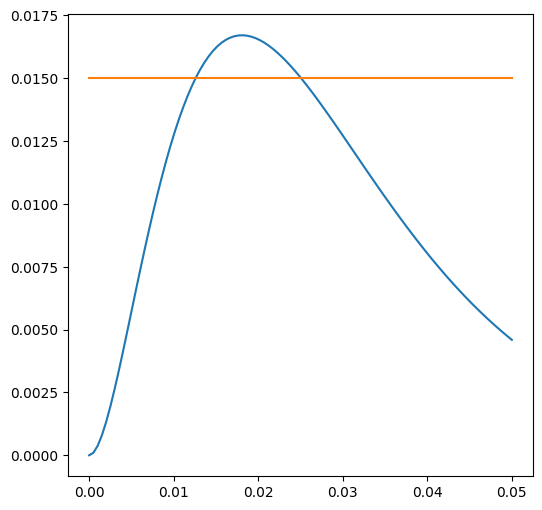

In [314]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.05, 100)

tau = 12e-3
a = 10
tau_m = 5e-3
b = 0.015

axs.plot(t, compute_current(t, tau, a, tau_m))
axs.plot(t, np.ones_like(t) * b)

t_0, t_1 = find_threshold_points(tau, a, tau_m, b)
print(t_0, t_1)

/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: overflow encountered in exp
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: overflow encountered in divide
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: invalid value encountered in add
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)


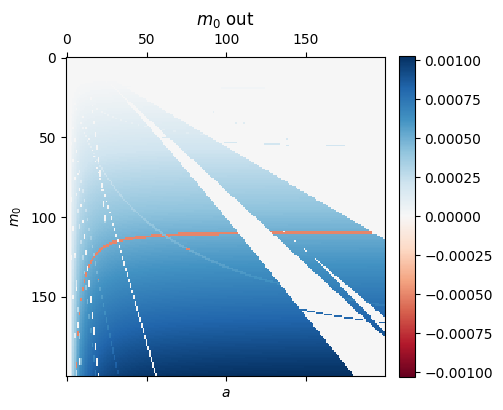

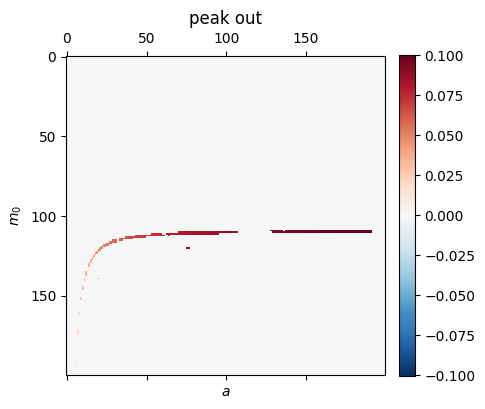

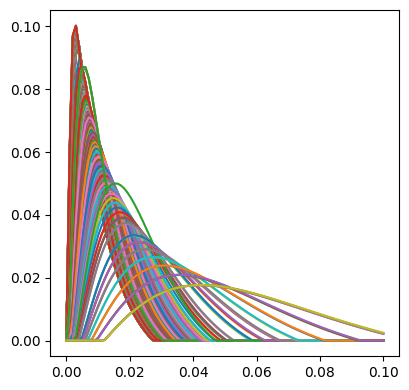

In [315]:
m_in = np.linspace(1e-4, 0.25, 200)
a = np.linspace(1, 500, 200)
tau_m = 5e-3
b = 0.01

m = np.zeros((200, 200))
peak = np.zeros((200, 200))

all_v = []

moment_locked_mask = np.zeros((200, 200))

for i, m_i in enumerate(m_in):
    for j, a_j in enumerate(a):
        tau_i = m_i / a_j
        m[i, j], peak[i, j] = compute_first_moment(tau_i, a_j, tau_m, b)
        m[i, j] = np.maximum(m[i, j], 0)

        if m[i, j] > 0.0005 * 0.99 and m[i, j] < 0.0005 * 1.01:
            m[i, j] = -0.0005
            moment_locked_mask[i, j] = 1
            
            v = np.maximum(compute_current(np.linspace(0, 0.05, 100), tau_i, a_j, tau_m) - b, 0)
            all_v.append(v)
         
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'$m_0$ out')

cbar = axs.matshow(m, cmap='RdBu', vmax=np.max(m), vmin=-np.max(m))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'peak out')

peak[~(moment_locked_mask.astype(bool))] = 0

cbar = axs.matshow(peak, cmap='RdBu_r', vmax=np.max(peak), vmin=-np.max(peak))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.1, 100)
for v in all_v:
    axs.plot(t, v)


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: overflow encountered in exp
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: overflow encountered in divide
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)
/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_17648/1501379517.py:3: RuntimeWarning: invalid value encountered in add
  return a * tau_m * (prod_tau * np.exp(-t/tau_m) + np.exp(-t/tau) * (tau * t - prod_tau - tau_m * t)) / np.square(tau - tau_m)


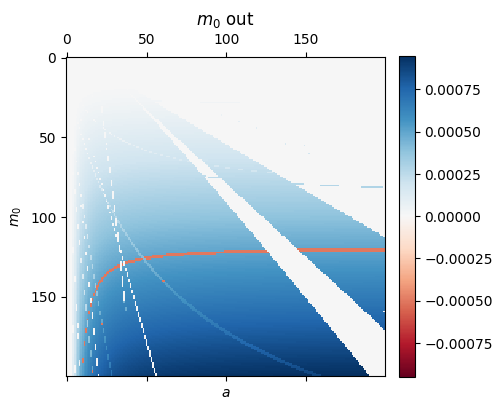

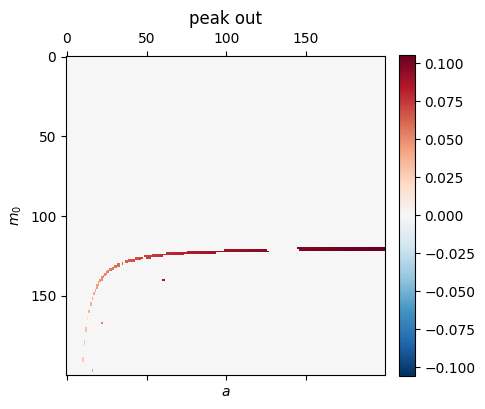

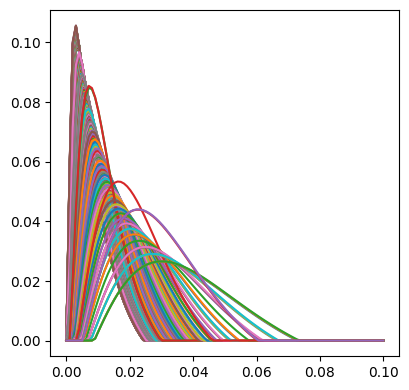

In [316]:
m_in = np.linspace(1e-4, 0.25, 200)
a = np.linspace(1, 500, 200)
tau_m = 5e-3
b = 0.015

m = np.zeros((200, 200))
peak = np.zeros((200, 200))

all_v = []

moment_locked_mask = np.zeros((200, 200))

for i, m_i in enumerate(m_in):
    for j, a_j in enumerate(a):
        tau_i = m_i / a_j
        m[i, j], peak[i, j] = compute_first_moment(tau_i, a_j, tau_m, b)
        m[i, j] = np.maximum(m[i, j], 0)

        if m[i, j] > 0.0005 * 0.99 and m[i, j] < 0.0005 * 1.01:
            m[i, j] = -0.0005
            moment_locked_mask[i, j] = 1
            
            v = np.maximum(compute_current(np.linspace(0, 0.05, 100), tau_i, a_j, tau_m) - b, 0)
            all_v.append(v)
         
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'$m_0$ out')

cbar = axs.matshow(m, cmap='RdBu', vmax=np.max(m), vmin=-np.max(m))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.set_title(r'peak out')

peak[~(moment_locked_mask.astype(bool))] = 0

cbar = axs.matshow(peak, cmap='RdBu_r', vmax=np.max(peak), vmin=-np.max(peak))
plt.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_ylabel(r'$m_{0}$')
axs.set_xlabel(r'$a$')

fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
t = np.linspace(0, 0.1, 100)
for v in all_v:
    axs.plot(t, v)

As the threshold increases, solutions must become more peaked to conserve $m_0$.

$\dot{b} = r_{\rm peak} - r_0$

This rule is a bit counterintuitive because solutions that are not peaked enough have their threshold increased, which in turn should decrease the peakedness of the response.

## Computational approach

Easiest thing to do is just to simulate this probably. Can I graph the flow in 2D for just E$\rightarrow$E homeostasis vs for both types?

In [125]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 0.5
b_set = 0.015
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        traj = [tau_alpha, a]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            inp = np.zeros_like(t)
            a_prime = a + np.random.normal(scale=0 * a)
            tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
            inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
            inp[:len(inp_alpha)] = inp_alpha
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (0.2 * (w_set - r_peak))
            b += (2 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak) 
        trajs[idx, :] = np.array(traj)
        idx += 1
        

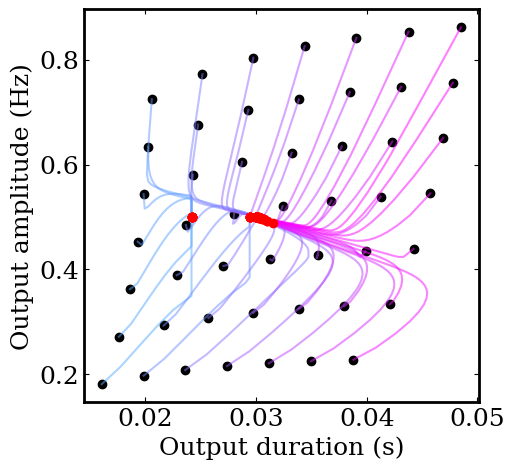

In [155]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    
    x_idxs = np.arange(2, len(traj), 2)
    y_idxs = np.arange(3, len(traj), 2)
    axs.plot(traj[x_idxs], traj[y_idxs], color=colors[i_traj], alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[2]], [traj[3]], color='black')
    axs.scatter([traj[-2]], [traj[-1]], color='red', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

In [135]:
trajs_inh = copy(trajs)

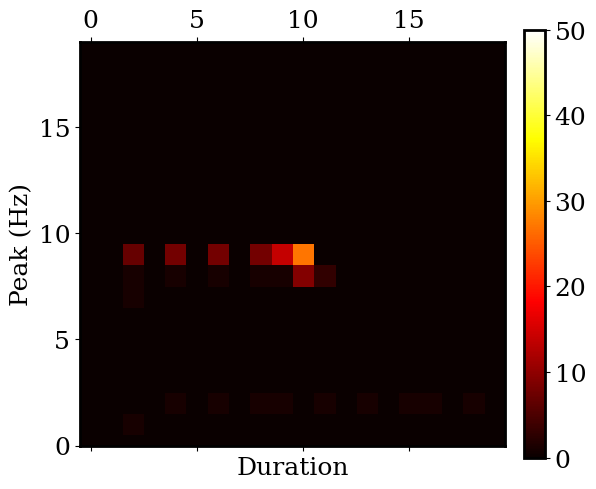

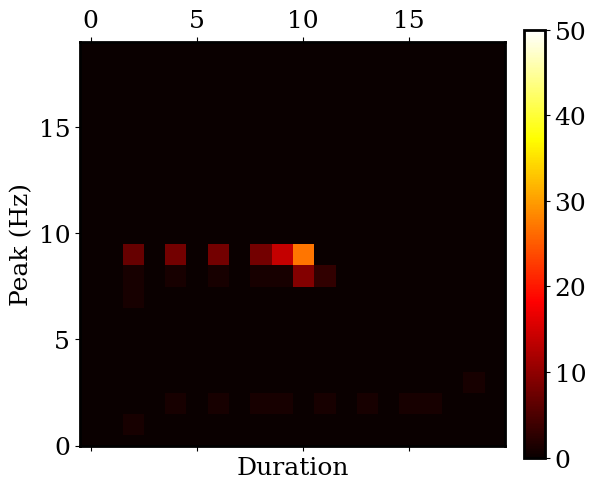

In [154]:
trajs = copy(trajs_inh)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[2 * i_cycle] / 0.06 * tiling_size), int(traj[(2 * i_cycle + 1)] / 1.1 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=50, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(0, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')

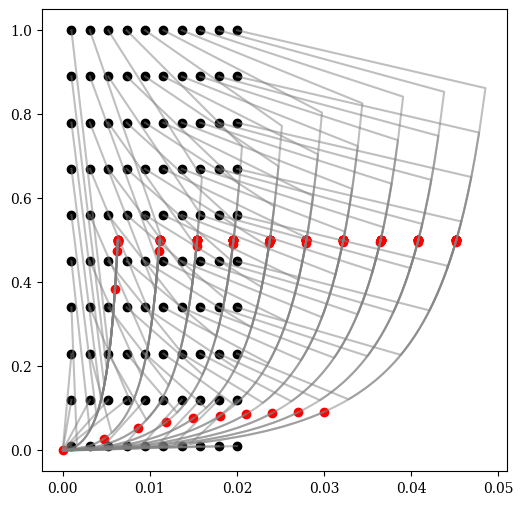

In [121]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 0.5
b_set = 0.05
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        traj = [tau_alpha, a]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            inp = np.zeros_like(t)
            a_prime = a + np.random.normal(scale=0 * a)
            tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
            inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
            inp[:len(inp_alpha)] = inp_alpha
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (0.2 * (w_set - r_peak))
#             b += (1 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak) 
        trajs[idx, :] = np.array(traj)
        idx += 1
        
        
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
for i_traj in range(trajs.shape[0]):
    traj = trajs[i_traj, :]
    
    x_idxs = np.arange(0, len(traj), 2)
    y_idxs = np.arange(1, len(traj), 2)
    axs.plot(traj[x_idxs], traj[y_idxs], color='gray', alpha=0.5)
    axs.scatter([traj[0]], [traj[1]], color='black')
    axs.scatter([traj[-2]], [traj[-1]], color='red')


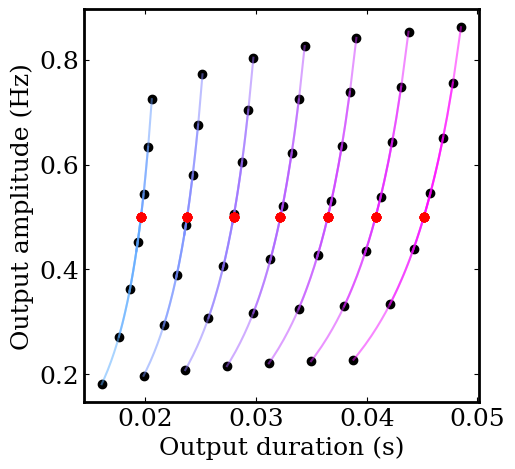

In [153]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    
    x_idxs = np.arange(2, len(traj), 2)
    y_idxs = np.arange(3, len(traj), 2)
    axs.plot(traj[x_idxs], traj[y_idxs], color=colors[i_traj], alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[2]], [traj[3]], color='black')
    axs.scatter([traj[-2]], [traj[-1]], color='red', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

In [124]:
trajs_exc = copy(trajs)

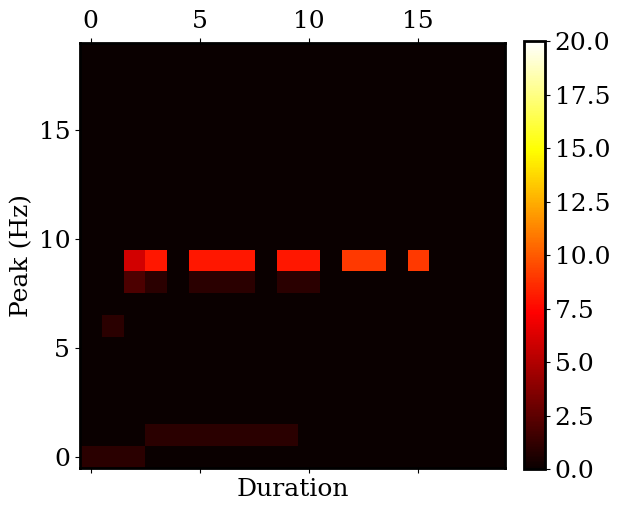

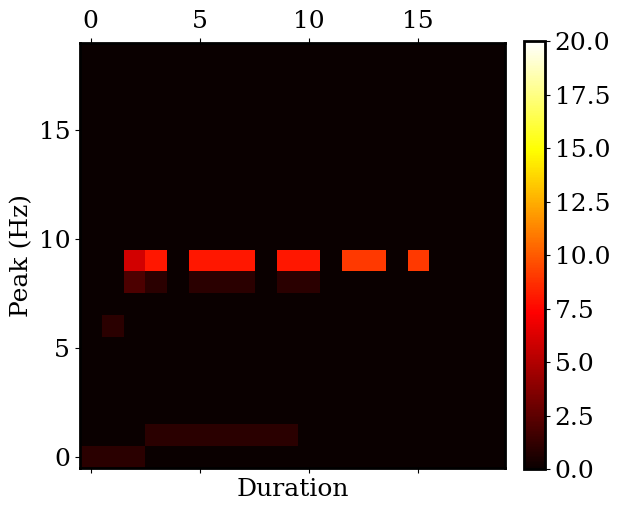

In [149]:
trajs = copy(trajs_exc)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[2 * i_cycle] / 0.06 * tiling_size), int(traj[(2 * i_cycle + 1)] / 1.1 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=20, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(-0.5, tiling_size - 1)
    axs.set_xlim(-0.5, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')